In [ ]:
%reset
from sympy import init_printing
from tqdm.auto import tqdm
import sympy as sp
import pandas as pd
import random
import string
import traceback
from func_timeout import func_set_timeout, FunctionTimedOut
init_printing()

**Vocabulary**

In [ ]:
symbol = lambda x: sp.Symbol(x, commutative = True)

In [ ]:
identifiers = [i for i in list(string.ascii_lowercase + string.ascii_uppercase) if i not in ['i','e','d','O']]

In [ ]:
symbols = [symbol(i) for i in identifiers]

**Rules**

In [ ]:
def add(x, y):
    
    if type(x) == sp.Equality:
        return sp.Eq(x.args[0] + y, x.args[1] + y)
    
    else:
        return x + y

In [ ]:
add(symbols[0], symbols[1])

In [ ]:
def minus(x, y):
    
    if type(x) == sp.Equality:
        return sp.Eq(x.args[0] - y, x.args[1] - y)
    
    else:
        return x - y

In [ ]:
def times(x, y):
    
    if type(x) == sp.Equality:
        return sp.Eq(x.args[0]*y, x.args[1]*y)
    
    else:
        return x*y

In [ ]:
def power(x, y):
    
    if type(x) == sp.Equality:
        return sp.Eq(x.args[0]**y, x.args[1]**y)
    
    else:
        return x**y

In [ ]:
def divide(x, y):
    
    if type(x) == sp.Equality:
        return sp.Eq(x.args[0]/y, x.args[1]/y)
    
    else:
        return x/y

In [ ]:
def differentiate(x, y):
    
    if type(x) == sp.Equality:
        return sp.Eq(sp.diff(x.args[0], y, evaluate=False), sp.diff(x.args[1], y, evaluate=False))
    
    else:
        y = random.choice(list(x.free_symbols))
        return sp.diff(x, y, evaluate = False)

In [ ]:
def integrate(x, y):
    
    if type(x) == sp.Equality:
        return sp.Eq(sp.Integral(x.args[0], y), sp.Integral(x.args[1], y))
    
    else:
        y = random.choice(list(x.free_symbols))
        return sp.Integral(x, y)

In [ ]:
def evaluate_integrals(x):
    # assumes derivation D is a global list of equations
    # D_local is a local copy of D which is edited within this function
    # assumes a list of symbols
    # does not integrate terms containing DOUBLE INTEGRALS or higher
    
    if not contains_double_integral(x):
    
        D_local = [i[0] for i in D.copy()]

        used_symbols = []
        for eq in D_local:
            used_symbols.extend(list(eq.free_symbols))

        integral_constants = [i for i in symbols if i not in used_symbols]

        if type(x) == sp.Integral:
            return x.doit() + random.choice(integral_constants)

        elif type(x) == sp.Equality:
            elems = get_equation_elements(x)

            integrals = [i for i in elems if type(i) == sp.Integral]

            subs = [(i, i.doit() + random.choice(integral_constants)) if str(sp.simplify(i)) != str(sp.simplify(i.doit())) else (i, i) for i in integrals]

            for i in subs:
                x = x.subs(i[0], i[1])

            return x

        else:
            return x
        
    else:
        return x
    
    # delete elses

In [ ]:
def evaluate_derivatives(x):
    
    if type(x) == sp.Derivative:
        return x.doit()
    
    elif type(x) == sp.Equality:
        elems = get_equation_elements(x)
        
        derivatives = [i for i in elems if (type(i) == sp.Derivative) and ('\int' not in sp.latex(i))]
        
        subs = [(i, i.doit()) for i in derivatives]
        
        for i in subs:
            x = x.subs(i[0], i[1])
            
        return x
    
    else:
        return x

In [ ]:
def cos(x):
    
    if type(x) == sp.Equality:
        return sp.Eq(sp.cos(x.args[0]), sp.cos(x.args[1]))
    
    else:
        return sp.cos(x)

In [ ]:
def sin(x):
    
    if type(x) == sp.Equality:
        return sp.Eq(sp.sin(x.args[0]), sp.sin(x.args[1]))
    
    else:
        return sp.sin(x)

In [ ]:
def exp(x):
    
    if type(x) == sp.Equality:
        return sp.Eq(sp.exp(x.args[0]), sp.exp(x.args[1]))
    
    else:
        return sp.exp(x)

In [ ]:
def log(x):
    
    if type(x) == sp.Equality:
        return sp.Eq(sp.log(x.args[0]), sp.log(x.args[1]))
    
    else:
        return sp.log(x)

In [ ]:
def expand(x):
    return sp.expand(x)

In [ ]:
def substitute_LHS_for_RHS(eq_1, eq_2):
    return eq_1.subs(eq_2.args[0], eq_2.args[1])

In [ ]:
def substitute_RHS_for_LHS(eq_1, eq_2):
    return eq_1.subs(eq_2.args[1], eq_2.args[0])

In [ ]:
def get_premise(symbols):
    
    rules_1 = [cos, sin, exp, log]
    rules_2 = [add, minus, times, power, divide, differentiate, integrate]
    
    arity = random.choice([1,2])

    if arity == 1:
        rule = random.choice(rules_1)
        sym = random.choice(symbols)
        RHS = rule(sym)
        LHS = random.choice([i for i in symbols if i != sym])

    elif arity == 2:
        rule = random.choice([i for i in rules_2 if i not in [differentiate, integrate]])
        sym_1 = random.choice(symbols)
        sym_2 = random.choice([i for i in symbols if i != sym_1])
        RHS = rule(sym_1, sym_2)
        LHS = random.choice([i for i in symbols if i not in [sym_1, sym_2]])
        

    # make RHS more complex
    complexity = random.choice(range(2))

    for i in range(complexity):
        
        arity = random.choice([1,2])
        
        if arity == 1:
            rule = random.choice(rules_1)
            RHS = rule(RHS)
            
        elif arity == 2:
            rule = random.choice(rules_2)
            sym = random.choice(symbols)
            
            RHS = rule(RHS, sym)
            
    LHS = sp.Function(LHS)(*tuple(RHS.free_symbols))

    eq = sp.Eq(LHS, RHS)
    
    return eq

In [ ]:
def renaming_premise(symbols):
    
    while True:
        elems = []
        for eq, _ in D:
            elems.extend(get_equation_elements(eq))

        elems = list(dict.fromkeys(elems))

        # more than one free symbol in RHS
        elems = [i for i in elems if len(list(i.free_symbols)) > 0 and len(str(i)) > 1]

        RHS = random.choice(elems)

        LHS = sp.Function(random.choice([i for i in symbols if i not in RHS.free_symbols]))(*tuple(RHS.free_symbols))
        
        if len(str(type(RHS))) > 1 and str(LHS) not in str(D):
            break

    return sp.Eq(LHS, RHS)

In [ ]:
def get_equation_elements(eq):

    args = list(eq.args)

    while True:

        old_length = len(args)

        for i in args:
            args.extend(i.args)

        args = list(dict.fromkeys(args))

        new_length = len(args)

        if new_length == old_length:
            break
            
    return [i for i in args if type(i) != sp.Tuple]

In [ ]:
contains_double_integral = lambda eq: True if True in ['iint' in sp.latex(i) for i in get_equation_elements(eq)] else False

In [ ]:
def pref_eqs(D, p):
    # makes the last equation p times more likely
    # equation n-i is p-i times more likely

    out = []

    new_D = D.copy()[-p:]
    new_D.reverse()
    for i in range(len(new_D)):
        if p-1 > i:
            out.extend([new_D[i]]*(p-i-1)**3)
        
    out.reverse()
    return D + out

In [ ]:
def valid_substitutions(rule_name, D):

    sub_options = []
    
    for i in D:
        for j in D:
            if str(i) != str(j):
                LHS, RHS = j.args
                
                if (type(LHS) is not sp.numbers.One) and (type(LHS) is not sp.numbers.Zero) and (type(RHS) is not sp.numbers.Zero) and (type(RHS) is not sp.numbers.One):
                
                    if rule_name == "substitute_LHS_for_RHS":

                        if (str(LHS) in str(i)) and (type(i.subs(LHS, RHS)) is sp.Equality) and (i.subs(LHS, RHS) != i):

                            pair = [D.index(i), D.index(j)]
                            sub_options.append(pair) if pair not in sub_options else 0

                    elif rule_name == "substitute_RHS_for_LHS":

                        if (str(RHS) in str(i)) and (type(i.subs(RHS, LHS)) is sp.Equality) and (i.subs(RHS, LHS) != i):

                            pair = [D.index(i), D.index(j)]
                            sub_options.append(pair) if (pair not in sub_options) and (pair[0] != pair[1]) else 0
                    
    return sub_options

In [ ]:
@func_set_timeout(5)
def step(D, p_history=10, p_arity_0=5, p_renaming=100, p_arity_1=50, p_evaluate=50, p_arity_2=100, p_int_or_diff=2, p_subs=30):
    
    
    # p_history: equation n-i is p-i times more likely (prioritises more recent equations like memory)
    # p_arity_0: overall probability multiplier for arity 0 functions
    # p_renaming: relevant prob multiplier for renaming premises
    # p_arity_1: overall probability multiplier for arity 1 functions
    # p_evaluate: relative probabilty of int or diff evaluations is multiplied by p_evaluate for arity 1 functions
    # p_arity_2: overall probability multiplier for arity 2 functions
    # p_int_or_diff: relative probability multiplier for int or diff compared to other arity 2 functions without multipliers
    # p_subs: same as p_int_or_diff but for substitution functions
    
    A = [i[1] for i in D] # only annotations
    D = [i[0] for i in D] # only equations
    
    rules_0 = [
        
        get_premise


    ] + [renaming_premise]*p_renaming
    

    rules_1 = [
        
        cos,
        sin,
        exp,
        log,
        expand
        
    ] + [evaluate_derivatives, evaluate_integrals]*p_evaluate
    
    
    rules_2 = [
        
        add,
        minus,
        times,
        divide,
        power
    
    ] + [differentiate, integrate]*p_int_or_diff + [substitute_LHS_for_RHS, substitute_RHS_for_LHS]*p_subs


    # assumes D has at least one equation so far
    relevant_equation_elements = []

    for eq in D:
        relevant_equation_elements.extend(get_equation_elements(eq))
    relevant_equation_elements = list(dict.fromkeys(relevant_equation_elements))

    arity = random.choice([0]*p_arity_0 + [1]*p_arity_1 +[2]*p_arity_2)
    
    elem_1 = 0
    
    if arity == 0:
        rule = random.choice(rules_0)
        eq = rule(symbols)
        annotation = rule.__name__

    if arity == 1:
        rule = random.choice(rules_1)

        # elem_1 can be equation
        elem_1 = random.choice(pref_eqs(D, p_history))
        eq = rule(elem_1)
                
        n = D.index(elem_1)
                
        annotation = [rule.__name__, n+1]
                

    if arity == 2:
        
        # no substitution rules if only 1 equation in D
        if len(D) == 1:
            
            rule = random.choice([i for i in rules_2 if 'subs' not in str(i.__name__)])
        else:
            
            rule = random.choice(rules_2)
        
        # substitution
        if ("subs" in rule.__name__):
            
            # alex says empty lists are falsey, a list with anything in is truthy,
            # so we only need `if valid_substitutions(rule.__name__, D)@`
            if valid_substitutions(rule.__name__, D) != []:
                

                n_1, n_2 = random.choice(valid_substitutions(rule.__name__, D))

                elem_1, elem_2 = D[n_1], D[n_2]
                
                annotation = [rule.__name__, n_1+1, n_2+1]
            
        
        # integration or differentiation
        elif rule.__name__ in ['integrate', 'differentiate']:
            
            # elem_1 can be an equation
            elem_1 = random.choice(pref_eqs(D, p_history))

            # elem_2 can be an equation with components in elem_1
            elem_2 = random.choice([i for i in get_equation_elements(elem_1) if len(str(i)) == 1 and str(i) not in string.digits])
            
            n = D.index(elem_1)
                    
            annotation = [rule.__name__, n+1, elem_2]
            
        
        # integration or differentiation
        elif rule.__name__ in ['power']:
            
            # elem_1 can be an equation
            elem_1 = random.choice(pref_eqs(D, p_history))

            # elem_2 can be an equation with components in elem_1
            elem_2 = random.choice([i for i in get_equation_elements(elem_1) if len(str(i)) < 3])
            
            n = D.index(elem_1)
                    
            annotation = [rule.__name__, n+1, elem_2]
            

        else:

            # elem_1 can be an equation
            elem_1 = random.choice(pref_eqs(D, p_history))

            # elem_2 can be an equation element
            elem_2 = random.choice([i for i in relevant_equation_elements if str(i) not in string.digits])
            
            n = D.index(elem_1)
                    
            annotation = [rule.__name__, n+1, elem_2]

        eq = rule(elem_1, elem_2)
        

    if type(eq) == sp.Equality:
            
        swapped_eq = sp.Eq(eq.args[1], eq.args[0])

        if (eq in D) or ('Subs' in str(eq)) or ('Piecewise' in str(eq)) or (swapped_eq in D) or len(sp.latex(eq)) >= 350:
            return False

        # success
        else:
            return (eq, annotation)

    else:
        return False

**Use annotations to only include relevant steps in a derivation**

In [ ]:
def extract_chain_starting_from_i(i, eq_pairs):
    # eq_pairs is a reverse chronological list of current equation numbers,
    # and the past equation numbers used to make them 
    # e.g., [30, 28], [29, 14], [28, 23, 2]
    
    chain = [eq_pairs[i]]


    while True:

        current_eq = chain[-1][0]
        used_eq = chain[-1][1]

        for pair in eq_pairs:

            last_eq = pair[0]
            if last_eq == used_eq:
                chain.append(pair)

        if (len(chain[-1]) == 1):
            #if pair not in chain: chain.append(pair)
            chain.append(pair) if pair not in chain else 0
            break

    chain_nums = []
    for i in chain:
        chain_nums.extend(i)

    valid_chain = [i for i in chain if len(i) == 1 and i[0] in chain_nums] + chain

    chain = [i for i in chain if i in valid_chain]

    return chain

In [ ]:
def merge_chains(chain, eq_pairs):
    
    # finds all chains which come from separate derivations that are substituted in
    # merges any new equations reverse chronologically

    while True:
    
        old_chain = chain.copy()

        first_numbers = [i[0] for i in chain]

        # unaccounted for eqs
        missing_eqs = [i[2] for i in chain if len(i) > 2] + [i[1] for i in chain if len(i) > 1 and i[1] not in first_numbers]

        for i in eq_pairs:
            chain.append(i) if (i[0] in missing_eqs) and i not in chain else 0

        if old_chain == chain:
            break

    chain_dict = {i[0]:i for i in chain}

    return sorted(chain)

In [ ]:
is_subset = lambda chain_1, chain_2: [i for i in chain_1 if i not in chain_2] == [] if chain_1 != chain_2 else False

In [ ]:
def extract_derivations(D):
    
    A = [[i+1] + list(D[i][1]) if type(D[i][1]) is list else [i+1, D[i][1]] for i in range(len(D))]

    A.reverse()

    eq_pairs = []

    for row in A:
        if 'subs' in str(row):
            eq_pairs.append([row[0], row[2], row[3]])
        elif 'premise' in str(row):
            eq_pairs.append([row[0]])
        else:
            eq_pairs.append([row[0], row[2]])

    chains = []
    for i in range(len(eq_pairs)-1):
        if len(eq_pairs[i]) > 1:
            chains.append(extract_chain_starting_from_i(i, eq_pairs))

    chains = [merge_chains(i, eq_pairs) for i in chains]

    final_chains = [i for i in chains.copy() if len(i) >= 3]
    for i in chains:
        for j in chains:
            if is_subset(i,j):
                try:
                    final_chains.remove(i)
                except:
                    pass

    derivations = []

    for n in range(len(final_chains)):
        D_idxs = [i[0]-1 for i in final_chains[n]]

        derivation = [D[n] for n in D_idxs]

        derivations.append(derivation)

    return derivations

In [ ]:
def fix_equation_indexes(derivation, D):

    good_bad_idxs = [[i+1,D.index(derivation[i])+1] for i in range(len(derivation))]

    for i in range(len(derivation)):
        for j in range(len(derivation[i][1])):
            for idx in good_bad_idxs:
                if derivation[i][1][j] == idx[1]:
                    derivation[i][1][j] = idx[0]
                    
    return derivation

In [ ]:
def create_df_row(derivation):

    data = []
    for i in range(len(derivation[:6])):
        row = []

        eq, annotation = derivation[i]

        row.append(i+1)

        if type(annotation) is str:
            row.append(annotation)
            row.extend(['','',''])

        else:
            if len(annotation) == 2:
                row.extend(annotation)
                row.append('')
                row.append('')

            else:
                row.extend(annotation[:2])

                sec_arg = annotation[-1]

                if type(sec_arg) is int:
                    row.append(sec_arg)
                    row.append('')

                else:
                    row.append(sp.latex(sec_arg))
                    row.append(sp.srepr(sec_arg))


        row.extend([sp.srepr(eq), sp.latex(eq)])  

        data.extend(row)
        
    cols = ['eq_idx_1', 'rule_1', 'arg_11', 'arg_12', 'arg_12_srepr', 'eq_1_srepr', 'eq_1',
        'eq_idx_2', 'rule_2', 'arg_21', 'arg_22', 'arg_22_srepr', 'eq_2_srepr', 'eq_2',
        'eq_idx_3', 'rule_3', 'arg_31', 'arg_32', 'arg_32_srepr', 'eq_3_srepr', 'eq_3',
        'eq_idx_4', 'rule_4', 'arg_41', 'arg_42', 'arg_42_srepr', 'eq_4_srepr', 'eq_4',
        'eq_idx_5', 'rule_5', 'arg_51', 'arg_52', 'arg_52_srepr', 'eq_5_srepr', 'eq_5',
        'eq_idx_6', 'rule_6', 'arg_61', 'arg_62', 'arg_62_srepr', 'eq_6_srepr', 'eq_6']

    df = pd.DataFrame(data).transpose()
    df.columns = cols
    
    return df

In [ ]:
def reconstruct_derivation(df, i, printing=False):

    row = list(df.iloc[i])
    d = []
    for i in range(7):
        j = 7*i
        d.append(row[j:j+7]) if row[j:j+7] != [] else 0

        
    d = [[sp.sympify(i[-2]),[i[1],i[2],i[3]]] if str(i[3]) in string.digits else [sp.sympify(i[-2]),[i[1],i[2],i[4]]] for i in d]

    new_d = []
    for i in d:
        eq, annotation = i

        annotation = [i for i in annotation if (str(i) != '') and (str(i) != 'nan')]

        if (len(annotation) > 1) and (str(annotation[-1]) not in string.digits):
            annotation[-1] = sp.sympify(annotation[-1])

        new_d.append((eq, annotation)) if len(annotation) > 1 else new_d.append((eq, annotation[0]))


    d = new_d
    
    if printing is True:
        
        j = 1
        for i in d:
            print(j)
            j += 1
            print(i[1])
            display(i[0])
            print('\n')
            
    else:
        
        return d

In [ ]:
def create_alternative_final_equations(df, i, d_size, error_log = False):

    D = reconstruct_derivation(df, i)[:d_size]
    
    #print(D,'\n\n')

    correct_eq = D[-1][0]
    
    D = D[:d_size-1]
    
    alternative_equations = []
    
    error_log = []

    while True:
        try:
            next_step = step(D)

        except Exception:
            next_step = False
            error = traceback.format_exc()
            error_log.append(error) if error not in error_log else 0

        eval_ints = [i[1] for i in D if 'evaluate_integrals' in str(i[1])]

        alternative_equations.append(next_step) if (next_step != False) and (str(next_step[0]) != str(correct_eq))\
        and (next_step[1] not in eval_ints) and (str(next_step[0]) not in str(alternative_equations))\
        and ('premise' not in str(next_step)) and (equation_contains_complicated_operand(next_step[0]) is False) else 0
        
        
        if len(alternative_equations) >= 4:
            break
    
    if error_log == True:
        return alternative_equations, error_log
    
    else:
        return [sp.srepr(i[0]) for i in alternative_equations] + [sp.latex(i[0]) for i in alternative_equations], [i[1] for i in alternative_equations]

**Main generation loop**

In [ ]:
df = pd.DataFrame(columns = ['eq_idx_1', 'rule_1', 'arg_11', 'arg_12', 'arg_12_srepr', 'eq_1_srepr', 'eq_1',
        'eq_idx_2', 'rule_2', 'arg_21', 'arg_22', 'arg_22_srepr', 'eq_2_srepr', 'eq_2',
        'eq_idx_3', 'rule_3', 'arg_31', 'arg_32', 'arg_32_srepr', 'eq_3_srepr', 'eq_3',
        'eq_idx_4', 'rule_4', 'arg_41', 'arg_42', 'arg_42_srepr', 'eq_4_srepr', 'eq_4',
        'eq_idx_5', 'rule_5', 'arg_51', 'arg_52', 'arg_52_srepr', 'eq_5_srepr', 'eq_5',
        'eq_idx_6', 'rule_6', 'arg_61', 'arg_62', 'arg_62_srepr', 'eq_6_srepr', 'eq_6'])

#df = pd.read_pickle('derivations_2.pkl')

#derivations = [reconstruct_derivation(df, i) for i in range(len(df))]

derivations = []

T = 12000 - len(df)

with tqdm(total=T) as pbar:

    while True:
        eq = get_premise(symbols)

        D = [(eq, "premise")]
        error_log = []

        while True:
            
            try:
                next_step = step(D)

            except Exception:
                error = traceback.format_exc()
                error_log.append(error) if error not in error_log else 0
                
            except:
                print('timeout')

            eval_ints = [i[1] for i in D if 'evaluate_integrals' in str(i[1])]

            D.append(next_step) if (next_step != False) and (next_step not in D) and (next_step[1] not in eval_ints) else 0
            
            if len(D) >= 6 and ('premise' not in str(D[-1])):
                break
        
        try:
            derivation = fix_equation_indexes(extract_derivations(D)[0], D)
        except:
            derivation = []


        if len(derivation) == 6:
            derivations.append(derivation)
            print(len(df)) if len(df) %10 == 0 else 0
            
            df = pd.concat([df, create_df_row(derivation)])
            df.to_pickle('derivations_2.pkl') if len(derivations) %10 == 0 else 0
            
            pbar.update(1)

        if len(df) >= T:
            break

In [ ]:
df = pd.read_pickle('next_equation_selection.pkl')

In [ ]:
next_equation_data = []
loop = tqdm(range(len(df)))
for i in loop:
    try:
        next_equation_data.append(create_alternative_final_equations(df[df.columns[:42]], i, 2)[0])
        print((i, 'ok'))
    except:
        print((i, 'bad'))

In [ ]:
len(next_equation_data)

In [ ]:
cols = ['neg_1_srepr', 'neg_2_srepr', 'neg_3_srepr', 'neg_4_srepr', 'neg_1', 'neg_2', 'neg_3', 'neg_4']

pd.DataFrame(next_equation_data, columns=cols)

In [ ]:
new_df = pd.concat([df[df.concat[:42]], pd.DataFrame(next_equation_data, columns=cols)], axis=1)

new_df

In [ ]:
new_df.to_pickle('next_equation_selection.pkl')

**Variable renaming** (also used to clean data further by removing incompatible derivations with complex function arguments)

In [ ]:
df = pd.read_pickle('next_equation_selection.pkl')

In [ ]:
def get_free_symbols_from_derivation(d):
    free_symbols = []
    
    for step in d:
        free_symbols.extend(list(step[0].free_symbols))
    
    return list(dict.fromkeys(free_symbols))

In [ ]:
def get_functions_from_derivation(d):
    functions = []

    for step in d:
        functions.extend(get_equation_elements(step[0]))

    return list(dict.fromkeys([i for i in functions if len(str(type(i))) == 1]))

In [ ]:
rename_function = lambda function, sym: sp.Function(sym)(*tuple(function.free_symbols))

In [ ]:
def get_swap_list(d):

    target_elements = get_functions_from_derivation(d) + get_free_symbols_from_derivation(d)
    #display(target_elements)

    bad_symbols = [symbol(str(type(i))) for i in get_functions_from_derivation(d)] + get_free_symbols_from_derivation(d)
    #display(bad_symbols)

    alternative_symbols = []
    while len(alternative_symbols) < len(target_elements):
        sym = random.choice(symbols)
        if (sym not in bad_symbols) and (sym not in alternative_symbols):
            alternative_symbols.append(sym)

    #display(alternative_symbols)


    swap_list = []
    for i in range(len(target_elements)):

        elem = target_elements[i]
        sym = alternative_symbols[i]

        if len(str(type(elem))) == 1:
            #display(rename_function(elem, sym))
            swap_list.append([elem, rename_function(elem, sym)])

        else:
            swap_list.append([elem, sym])

    return swap_list

In [ ]:
get_derivation_and_negative_examples = lambda df, i: (reconstruct_derivation(df[df.columns[:42]], i), [sp.sympify(i) for i in list(df[df.columns[42:46]].iloc[i])])

In [ ]:
is_math = lambda elem: str(elem) not in string.digits and type(elem) is not str

In [ ]:
def rename_variables(math, swaps):
    
    for pair in swaps:
        math = math.subs(pair[0], pair[1])
    
    return math

In [ ]:
def equation_contains_complicated_operand(eq):
    
    funcs = get_equation_elements(eq)

    funcs = list(dict.fromkeys([i for i in funcs if len(str(type(i))) == 1]))

    func_args = []
    for func in funcs:
        func_args.extend(list(func.args))

    arg_lens = [len(str(arg)) for arg in func_args if len(str(arg)) > 1]

    if arg_lens:
        return True

    else:
        return False

In [ ]:
def contains_a_func_of_a_complicated_operand(df, i):

    d, negs = get_derivation_and_negative_examples(df, i)

    eqs = [i[0] for i in d] + negs

    funcs = []
    for eq in eqs:
        funcs.extend(get_equation_elements(eq))

    funcs = list(dict.fromkeys([i for i in funcs if len(str(type(i))) == 1]))

    func_args = []
    for func in funcs:
        func_args.extend(list(func.args))

    arg_lens = [len(str(arg)) for arg in func_args if len(str(arg)) > 1]

    if arg_lens:
        return True

    else:
        return False

In [ ]:
# this identifies all df entries with weird functions

bad_idxs = []

loop = tqdm(range(len(df)))

for i in loop:
    
    try:
        if contains_a_func_of_a_complicated_operand(df, i):
            bad_idxs.append(i)
            
    except:
        print(i)
        bad_idxs.append(i)

In [ ]:
# # remove entries with complex function operands

# new_df = pd.DataFrame([df.iloc[i] for i in range(len(df)) if i not in bad_idxs], columns = df.columns)

# new_df.index = range(len(new_df))

# new_df.to_pickle('next_equation_selection.pkl')

In [ ]:
def get_derivation_from_example(example, printing=False, negative_equations=False):

    d = example["srepr_derivation"]

    derivation = []

    for step in d:

        annotation, eq = step

        eq = sp.sympify(eq)

        if type(annotation) is list:

            annotation = [sp.sympify(elem) if "commutative" in str(elem) else elem for elem in annotation]

        derivation.append([eq, annotation])
        
    if printing is True:
        
        for i in range(len(derivation)):
            
            eq, annotation = derivation[i]
            
            print(i+1,'\n', annotation)
            display(eq)
            
            print('\n')
            
        if negative_equations is True:

            for neg in [sp.sympify(neg) for neg in example["srepr_negatives"]]:
                display(neg)
                
            print('\n')
            
            
    if negative_equations is True:
        
        return derivation, [sp.sympify(neg) for neg in example["srepr_negatives"]]
        
    return derivation

In [ ]:
def create_example(derivation_and_negs, positive_idxs):
    # from ACTUAL derivation
    # also outputs srepr for reproducing derivations
    
    derivation, negs = derivation_and_negs

    latex_derivation = []
    srepr_derivation = []
    

    for step in derivation:

        eq, annotation = step

        latex_eq = sp.latex(eq)
        srepr_eq = sp.srepr(eq)

        if type(annotation) is list:
            latex_annotation = [sp.latex(elem) if is_math(elem) else elem for elem in annotation]
            srepr_annotation = [sp.srepr(elem) if is_math(elem) else elem for elem in annotation]

        else:
            latex_annotation = annotation
            srepr_annotation = annotation

        latex_derivation.append([latex_annotation, latex_eq])
        srepr_derivation.append([srepr_annotation, srepr_eq])
        
        
    latex_derivation = clean_derivation(latex_derivation)
        

    latex_negs = [sp.latex(neg).replace("\\left","").replace("\\right","").replace(' )',')') for neg in negs]
    srepr_negs = [sp.srepr(neg) for neg in negs]

    example = {
        "derivation":latex_derivation,
        "positive_idxs":positive_idxs,
        "negatives":latex_negs,
        "srepr_derivation":srepr_derivation,
        "srepr_negatives":srepr_negs
    }
    
    return example

**Convert to json**

In [ ]:
#data = [get_derivation_and_negative_examples(df, i) for i in range(len(df))]

data = [[reconstruct_derivation(df[df.columns[:42]], i)[:2], [sp.sympify(j) for j in next_equation_data[i][:4]]] for i in range(len(df))]

In [ ]:
# check data

d, negs = data[12300]

for i in d:
    
    print(i[1],'\n')
    display(i[0])
    print('\n\n')
    
for i in negs:
    display(i)

In [ ]:
idxs = [2]

latex_derivations = []
latex_negatives = []
srepr_derivations = []
srepr_negatives = []

loop = tqdm(range(len(data)))

for i in loop:

    derivation, negs = data[i]

    latex_derivation = []
    srepr_derivation = []

    for step in derivation:

        eq, annotation = step
        
        latex_eq = sp.latex(eq)
        srepr_eq = sp.srepr(eq)

        if type(annotation) is list:
            latex_annotation = [sp.latex(elem) if is_math(elem) else elem for elem in annotation]
            srepr_annotation = [sp.srepr(elem) if is_math(elem) else elem for elem in annotation]
            
        else:
            latex_annotation = annotation
            srepr_annotation = annotation

        latex_derivation.append((latex_annotation, latex_eq))
        srepr_derivation.append((srepr_annotation, srepr_eq))

    latex_derivations.append(latex_derivation)
    srepr_derivations.append(srepr_derivation)

    latex_negatives.append([sp.latex(neg) for neg in negs])
    srepr_negatives.append([sp.srepr(neg) for neg in negs])

In [ ]:
def clean_derivation(d):
    
    # gets rid of unwanted text such as \\left / \\right
    
    # keeps step = (annotation, eq) format

    new_d = []

    for step in d:

        annotation, eq = step

        eq = eq.replace("\\left","").replace("\\right","").replace(' )',')')

   
        if type(annotation) is list:
            
            
            annotation = [elem.replace("\\left","").replace("\\right","").replace(' )',')') if "\\left" in str(elem) or "\\right" in str(elem) else elem for elem in annotation]


        new_d.append((annotation, eq))
        
        
    return new_d

In [ ]:
all_data = []

for i in range(len(data)):
    all_data.append({'derivation':clean_derivation(latex_derivations[i]),
                      'positive_idxs':idxs,
                      'negatives':[eq.replace("\\left","").replace("\\right","").replace(' )',')') for eq in latex_negatives[i]],
                      'srepr_derivation':srepr_derivations[i],
                      'srepr_negatives':srepr_negatives[i]})

In [ ]:
import json
import numpy as np

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [ ]:
import json
with open('next_equation_selection_steps=2.json', 'w') as f:
    json.dump(all_data, f, cls = NpEncoder)

In [ ]:
import numpy as np
import json
d_file = open('next_equation_selection_steps=2.json','r')
d_json = json.load(d_file)

In [ ]:
i = 2823

example = d_json[i]

In [ ]:
def rename_derivation_variables(example):
    
    #d, negs = get_derivation_and_negative_examples(df, i)
    
    d, negs = get_derivation_from_example(example, negative_equations=True)

    new_d = []

    swaps = get_swap_list(d)
    
    #display(swaps)
    
    for i in range(len(d)):

        row = []
        for j in range(len(d[i])):

            if type(d[i][j]) is list:
                annotation = []
                for k in range(len(d[i][j])):

                    if is_math(d[i][j][k]):

                        annotation.append(rename_variables(d[i][j][k], swaps))

                    else:
                        annotation.append(d[i][j][k])

                row.append(annotation)

            elif type(d[i][j]) is sp.Equality:
                row.append(rename_variables(d[i][j], swaps))

            else:
                row.append(d[i][j])

        new_d.append(tuple(row))

    
    new_negs = [rename_variables(i, swaps) for i in negs]

    return new_d, new_negs

In [ ]:
# create variable renaming data

var_data = []

loop = tqdm(d_json)
for example in loop:
    
    var_data.append(create_example(rename_derivation_variables(example),positive_idxs=[2]))

In [ ]:
import json
with open('next_equation_selection_VAR_RENAMING_steps=2.json', 'w') as f:
    json.dump(var_data, f, cls = NpEncoder)

In [ ]:
def expression_exchange_in_derivation(example):
    
    d, negs = get_derivation_from_example(example, negative_equations=True)

    new_d = []
    for step in d:

        eq, annotation = step

        LHS, RHS = eq.args

        new_eq = sp.Equality(RHS, LHS)

        if type(annotation) is list:
            rule = annotation[0]

            if rule == 'substitute_LHS_for_RHS':
                annotation = ['substitute_RHS_for_LHS'] + [elem for elem in annotation[1:]]

            elif rule == 'substitute_RHS_for_LHS':
                annotation = ['substitute_LHS_for_RHS'] + [elem for elem in annotation[1:]]

        new_d.append([new_eq, annotation])
        
    
    new_negs = []
    
    for neg in negs:
        
        LHS, RHS = neg.args
        new_neg = sp.Equality(RHS, LHS)
        new_negs.append(new_neg)
        
    return new_d, new_negs

In [ ]:
# create exchange data

exchange_data = []

loop = tqdm(d_json)
for example in loop:
    
    exchange_data.append(create_example(expression_exchange_in_derivation(example),positive_idxs=[2]))

In [ ]:
import json
with open('next_equation_selection_EXPR_EXCHANGE_steps=2.json', 'w') as f:
    json.dump(exchange_data, f, cls = NpEncoder)

In [202]:
op_swap = []

loop = tqdm(d_json)

for example in loop:
    
    d, negs = get_derivation_from_example(example, negative_equations=True)

    correct_eq = d[-1][0]

    D = d[:-1]

    random.shuffle(negs)

    target_eq = negs[0]

    while True:
        
        try:
            next_step = step(D)
        
        except FunctionTimedOut:
            pass

        if next_step is not False:
            if str(next_step[0]) == str(target_eq):
                #print(next_step)
                break

    negs.remove(target_eq)

    negs.append(correct_eq)

    random.shuffle(negs)

    derivation = [list(step) for step in D] + [list(next_step)]


    derivation_and_negs = derivation, negs

    
    op_swap.append(create_example(derivation_and_negs, positive_idxs=[2]))

In [206]:
import json
with open('next_equation_selection_OP_SWAP_steps=2.json', 'w') as f:
    json.dump(op_swap, f, cls = NpEncoder)

1 
 premise




2 
 ['differentiate', 1, H]


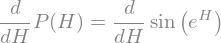

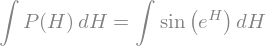

([[Eq(P(H), sin(exp(H))), 'premise'],
  [Eq(Derivative(P(H), H), Derivative(sin(exp(H)), H)),
   ['differentiate', 1, H]]],
 [Eq(Integral(P(H), H), Integral(sin(exp(H)), H)),
  Eq(P(H)**2, P(H)*sin(exp(H))),
  Eq(P(H)*exp(H), exp(H)*sin(exp(H))),
  Eq(log(P(H)), log(sin(exp(H))))])

In [207]:
get_derivation_from_example(example, True, True)

1 
 premise




2 
 ['times', 1, P(H)]


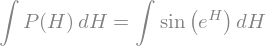

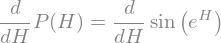

([[Eq(P(H), sin(exp(H))), 'premise'],
  [Eq(P(H)**2, P(H)*sin(exp(H))), ['times', 1, P(H)]]],
 [Eq(P(H)*exp(H), exp(H)*sin(exp(H))),
  Eq(Integral(P(H), H), Integral(sin(exp(H)), H)),
  Eq(log(P(H)), log(sin(exp(H)))),
  Eq(Derivative(P(H), H), Derivative(sin(exp(H)), H))])

In [208]:
get_derivation_from_example(op_swap[-1], True, True)